<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/R_th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import seaborn as sns
sns.set()
#plt.style.use('fast')
#plt.rc('font', size = 14, family ='Sans-Serif')
def panda_from_gspreadsheet(key, sheet_name='Sheet1', header=0):
  # google spredsheet TO panda dataframe 
  # ricordarsi di abilitare lo sharing pubblico dei dati
  url = 'https://docs.google.com/spreadsheets/d/{key}/gviz/tq?tqx=out:csv&sheet={sheet_name}&headers=1'.format(
      key=key, sheet_name=sheet_name.replace(' ', '%20'))
  return pd.read_csv(url, header=header)
 
# DATI COVID Nazionali https://github.com/pcm-dpc/COVID-19
# download updated data
# repository italy https://github.com/pcm-dpc/COVID-19/tree/master/dati-andamento-nazionale
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url_csv_file)
# DATI COVID REGIONI
# istat http://dati.istat.it/Index.aspx?QueryId=26428#
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
dr = pd.read_csv(url_csv_file)
Lombardia = dr.loc[(dr['denominazione_regione'] == 'Lombardia')].sort_values(by="data").copy()
Lazio = dr.loc[(dr['denominazione_regione'] == 'Lazio')].sort_values(by="data").copy()
Italia = df.copy() 
# DATI Popolazione Regioni
dpr = panda_from_gspreadsheet('1qL5B_J6eV6bD9zicR0YsCIaUMU0BhTdSTrqC1UcDBI8', sheet_name='Sheet1')
# DATI COVID Provincie
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv"
dp = pd.read_csv(url_csv_file)
pr =  panda_from_gspreadsheet('1Hf3s74TRWnhLkKYOM3XOdFwqyZEuxkl0Rxx8xjLmeZs', sheet_name='Sheet1')
 
print('aggiornamento al '+str(np.array(df['data'])[-1])[0:10])
def Exp(x, p0, p1): # negative exponential
    import numpy as np
    return p0*np.exp(x/p1)
 
def Infected(t, I0, mu, R0): # negative exponential
    import numpy as np
# https://medium.com/data-for-science/epidemic-modeling-101-or-why-your-covid19-exponential-fits-are-wrong-97aa50c55f8
    return I0*np.exp(mu*(R0-1)*t)
 
# def Logistic(x, L, k, x0):
#     import numpy as np
#     return L / (1. + np.exp(-k * (x - x0)))
 
def Logistic(x, a, b, c):
    import numpy as np
# https://it.wikipedia.org/wiki/Equazione_logistica
    return a / (1. + b * np.exp(-c * x))
 
def Logistic4(x, a, b, c, d):
    import numpy as np
# https://it.wikipedia.org/wiki/Equazione_logistica
    return a / (1. + b * np.exp(-c * x)) + d
 
def dLogistic(x, a, b, c):
    import numpy as np
    return a*b*c*np.exp(c*x)/(b+np.exp(c*x))**2
 
def Gompertz(x, a, b, c):
    import numpy as np
# https://en.wikipedia.org/wiki/Gompertz_function
    return a * np.exp(-b * np.exp(-c * x))
 
def dGompertz(x, a, b, c):
  import numpy as np
# https://en.wikipedia.org/wiki/Gompertz_function
  return a*b*c * np.exp(-b * np.exp(-c * x))*np.exp(-c * x)
 
def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))
 
def Line(x, m, q):
    import numpy as np
    return m*x + q
 
def ManSdtSubArr(arr, rescaled_avarege):
  import numpy as np
  if len(arr)>rescaled_avarege & rescaled_avarege>1:
    a_split     = np.array_split(arr, int(len(arr)/rescaled_avarege))
    a_split_avg = [np.mean(x) for x in a_split]
    a_split_err = [np.std(x) for x in a_split]
    x = np.linspace(0, len(a_split_avg)*rescaled_avarege, len(a_split_avg))
    return x, np.array(a_split_avg), np.array(a_split_err)
  else:
    x = np.linspace(0, len(arr)*rescaled_avarege, len(arr))
    return x, np.array(arr), np.sqrt(arr)
    
def fittalo(func, x, y, ax, p0, fmt='k'):
  from scipy.optimize import curve_fit
  from sklearn.metrics import r2_score
  popt, pcov = curve_fit(func,x, y, p0=p0)
  perr = np.sqrt(np.diag(pcov))
  r2=r2_score(y, func(x, *popt))
  xf = np.linspace(x.min(), x.max(), 100)
  ax.plot(xf, func(xf, *popt), fmt, label='a = {0:.2e}±{1:.2e}\nb = {2:.2e}±{3:.2e} \
  \nc = {4:.2e}±{5:.2e}\nr^2 = {6:.3f}'.format(popt[0], perr[0], popt[1], perr[1], popt[2], perr[2], r2))
  return ax, popt
 
def Rth(data, N=7, d=4):
  # https://www.facebook.com/DatiAnalisiCoronavirus/posts/142436764043174?__tn__=K-R
  # faq ISS https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt
  y = np.convolve(data, np.ones((N,))/N, mode='valid')
  x = np.linspace(0, len(y), len(y))
  return x[d:] , y[d:]/y[:-d]

aggiornamento al 2022-01-18


In [2]:
dr.tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2
14590,2022-01-18T17:00:00,ITA,19,Sicilia,38.115697,13.362357,1389,170,1559,182579,184138,7384,8606,343117,8010,NaN,NaN,535265,9242493,3699731.0,DECEDUTI: N. 2 IL 18/01/22 -N. 23 IL 17/01/22 ...,13.0,NaN,NaN,447660.0,87605.0,4084086.0,5158407.0,ITG,ITG1
14591,2022-01-18T17:00:00,ITA,9,Toscana,43.769231,11.255889,1318,131,1449,178366,179815,1044,14799,414133,7892,NaN,NaN,601840,10248876,3966836.0,NaN,8.0,NaN,NaN,449515.0,152325.0,5816686.0,4432190.0,ITI,ITI1
14592,2022-01-18T17:00:00,ITA,10,Umbria,43.106758,12.388247,206,11,217,26434,26651,-1029,2421,102872,1568,NaN,NaN,131091,3221470,599308.0,Si fa presente che 5 dei ricoveri non UTI appa...,1.0,NaN,NaN,98446.0,32645.0,1419199.0,1802271.0,ITI,ITI2
14593,2022-01-18T17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,76,8,84,5573,5657,-339,526,18493,497,NaN,NaN,24647,405170,120362.0,NaN,0.0,NaN,NaN,14553.0,10094.0,130521.0,274649.0,ITC,ITC2
14594,2022-01-18T17:00:00,ITA,5,Veneto,45.434905,12.338452,1569,184,1753,254161,255914,-360,25166,644343,12797,NaN,NaN,913054,21683754,2566507.0,NaN,20.0,NaN,NaN,655431.0,257623.0,8726241.0,12957513.0,ITH,ITH3


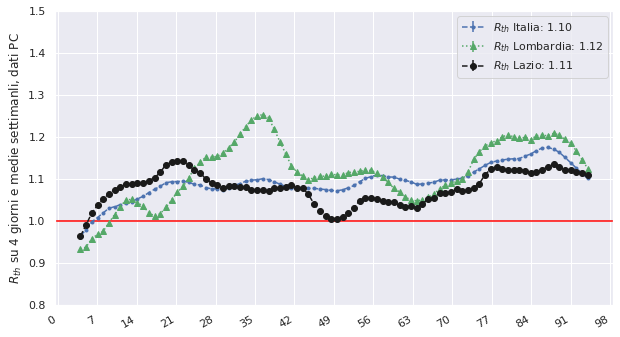

In [3]:
fig, ax = plt.subplots(figsize=(10,6))
N = 7
d = 4
what = 'nuovi_positivi'
what = 'ricoverati_con_sintomi' # faq ISS https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt
cut = -100
data = df[what][cut:]
x , y = Rth(data, N, d)
ax.errorbar(x , y, yerr=0, fmt='b.--', label='$R_{th}$'+' Italia: {0:.2f}'.format(y[-1]))
 
data = Lombardia[what][cut:]
x , y = Rth(data, N, d)
ax.errorbar(x, y, yerr=0, fmt='g^:', label='$R_{th}$'+' Lombardia: {0:.2f}'.format(y[-1]))
 
data = Lazio[what][cut:]
x , y = Rth(data, N, d)
ax.errorbar(x , y, yerr=0, fmt='ko--', label='$R_{th}$'+' Lazio: {0:.2f}'.format(y[-1]))
 
ax.axhline(1, color='red')
ax.set_ylabel(r'$R_{th}$ su 4 giorni e medie settimanli, dati PC')
ax.xaxis.set_major_locator(MultipleLocator(7))
 
ax.set_ylim(0.8,1.5)
fig.autofmt_xdate()
ax.legend()
#ax.grid()) 
#sns.set_theme()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


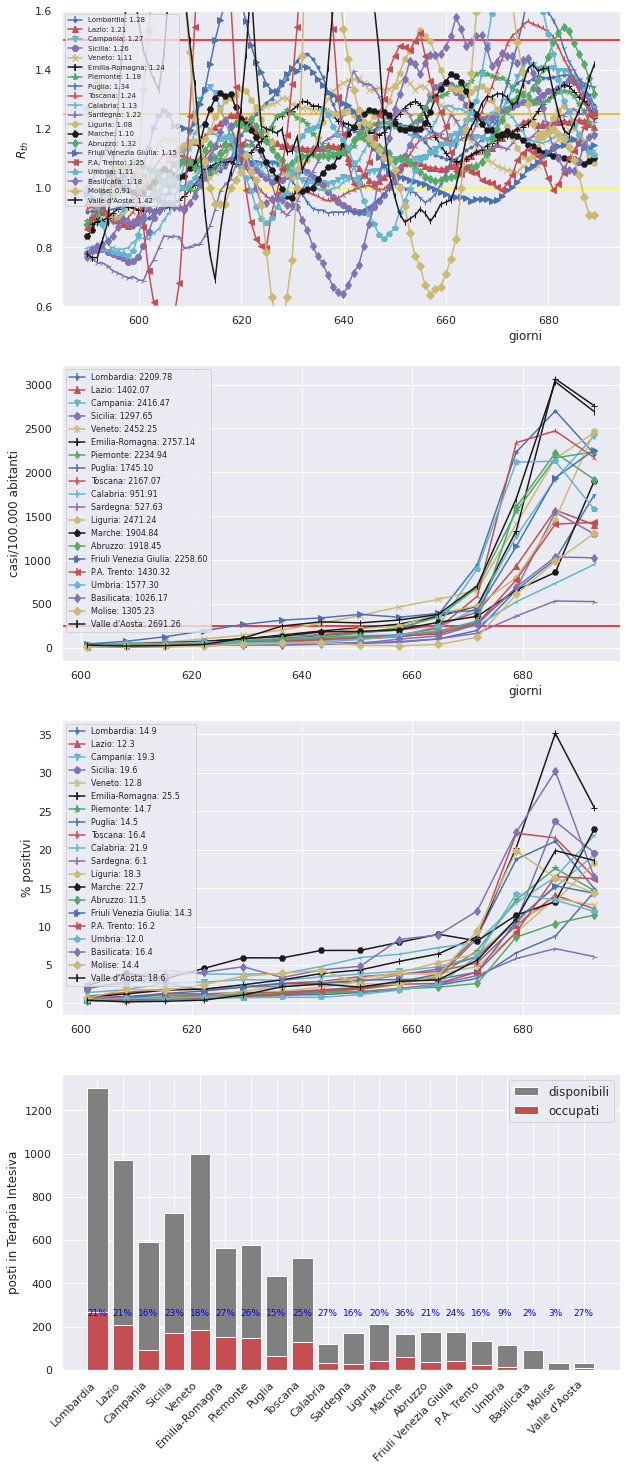

In [4]:
col    = ('b.-', 'r^-', 'cv-', 'mo-', 'yx-', 'k+-', 'g*-', 'b1-', 'r2-', 'c3-', 'm4-', 'yh-', 'kH-', 'gd-', 'b>-', 'r<-', 'cp-', 'md-', 'yD-', 'k|-', 'g,-')
regioni = np.array(dpr['Regione'])
ti = np.array(dpr['terapia_intensiva'])
tie = np.array(dpr['ti_esitenti'])
agenas = np.array(dpr['agenas'])
tir  = []
RthL = []
days = 100
people = np.array(dpr['Popolazione'])/100
fig, ax = plt.subplots((4), figsize=(10,25))
for r in range(0, len(regioni)):
  if regioni[r]=='Trentino Alto Adige':
    
    regioni[r] = 'P.A. Trento'
  drt = dr.loc[(dr['denominazione_regione'] == regioni[r])].sort_values(by="data").copy()
 
  data = np.array(drt['ricoverati_con_sintomi'])
  x , y = Rth(data, 7, 7)
  RthL.append(y[-1])
  average_day=7
  ax[0].errorbar(x[-days:], y[-days:], yerr=0, fmt=col[r], label='{0:s}: {1:.2f}'.format(regioni[r],y[-1]))
  tir.append(np.array(drt['terapia_intensiva'])[-1])
  data2 = np.array(drt['nuovi_positivi'])/people[r]
  x, y, err = ManSdtSubArr(data2, average_day)
  ax[1].errorbar(x[-np.int(days/average_day):], y[-np.int(days/average_day):]*average_day, yerr=0, fmt=col[r], label='{0:s}: {1:.2f}'.format(regioni[r],y[-1]*average_day))
  data3 = np.array(drt['nuovi_positivi'])/np.gradient(drt['tamponi'])
  x, y, err = ManSdtSubArr(data3, average_day)
  ax[2].errorbar(x[-np.int(days/average_day):], y[-np.int(days/average_day):]*100, yerr=0, fmt=col[r], label='{0:s}: {1:.1f}'.format(regioni[r],y[-1]*100))
 
ax[3].bar(regioni, agenas, width=0.8, color='gray', align='center', label='disponibili')
ax[3].bar(regioni, tir, width=0.8, color='r', align='center', label='occupati')
for i in range(regioni.size):
  plt.annotate('{:.0f}%'.format(100*tir[i]/agenas[i]), (i-0.4,250), fontsize=9, color='blue')
 
ax[0].legend(loc=2, prop={'size': 7})
ax[0].set_ylim(bottom=0.6, top=1.6)
ax[0].axhline(1.5, color='red')
ax[0].axhline(1.25, color='orange')
ax[0].axhline(1, color='yellow')
#ax[0].grid()
ax[0].set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax[1].set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax[0].set_ylabel('$R_{th}$', horizontalalignment = 'left', x=0.8)
ax[1].set_ylabel('casi/100.000 abitanti')
ax[1].axhline(250, color='red')
ax[1].legend(loc=2, prop={'size': 8})
#ax[1].grid()
ax[2].set_ylabel('% positivi')
ax[2].legend(loc=2, prop={'size': 8})
#ax[2].grid()
ax[3].set_ylabel('posti in Terapia Intesiva')
ax[3].legend(loc=0, prop={'size': 12})
plt.setp(ax[3].get_xticklabels(), rotation=45, ha='right')
plt.show()

In [5]:
def DataRegione(regione='Lazio', average_day=7, verbose=False):
  # DATI Popolazione Regioni
  dpr = panda_from_gspreadsheet('1qL5B_J6eV6bD9zicR0YsCIaUMU0BhTdSTrqC1UcDBI8', sheet_name='Sheet1')
  ti = dpr[dpr.Regione==regione].terapia_intensiva.values[0]
  tie = dpr[dpr.Regione==regione].ti_esitenti.values[0]
  agenas = dpr[dpr.Regione==regione].agenas.values[0]
  people = dpr[dpr.Regione==regione].Popolazione.values[0]/100
  drt = dr.loc[(dr['denominazione_regione'] == regione)].sort_values(by="data").copy()
  data = np.array(drt['ricoverati_con_sintomi'])
  x , y = Rth(data, average_day, 4)
  if verbose: print('{0:s}'.format(regione))
  Rt = y[-1]
  if verbose: print('{0:s}: {1:.2f}'.format("Rth",Rt))
  data2 = np.array(drt['nuovi_positivi'])/people
  x, y, err = ManSdtSubArr(data2, average_day)
  casi = y[-1]*average_day  
  if verbose: print('{0:s}: {1:.2f}'.format("casi/100.000",casi))
  data3 = np.array(drt['nuovi_positivi'])/np.gradient(drt['tamponi'])
  x, y, err = ManSdtSubArr(data3, average_day)
  positivita = y[-1]*100
  if verbose: print('{0:s}: {1:.1f}'.format("positivita",positivita))
  tir = (drt['terapia_intensiva'].values)[-1]
  if verbose: print('{0:s}: {1:.1f}'.format("TI",tir))
  occupazione = 100*tir/agenas
  if verbose: print('{0:s}: {1:.0f}%'.format("Occupazione",occupazione))
  return Rt, casi, positivita, tir, occupazione
DataRegione(regione='Lazio', average_day=7, verbose=True)


Lazio
Rth: 1.11
casi/100.000: 1402.07
positivita: 12.3
TI: 207.0
Occupazione: 21%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


(1.1079017569680802,
 1402.072636510258,
 12.312166080627044,
 207,
 21.362229102167184)

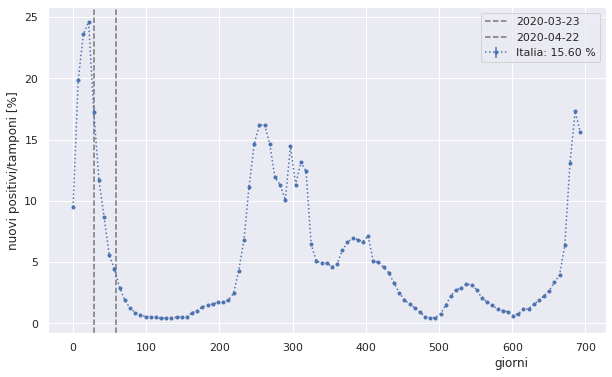

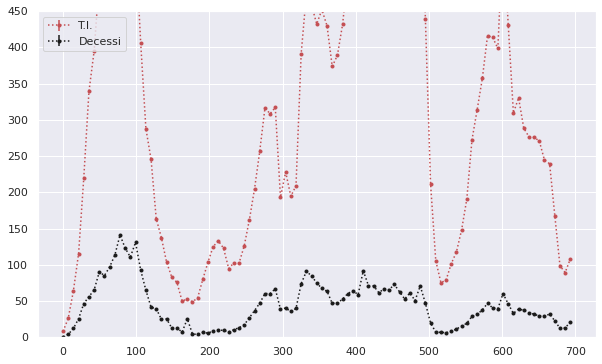

In [6]:
def tamp_perc(average_day=1):
  fig, ax = plt.subplots(figsize=(10,6))
  x = np.linspace(0, len(df['data']), len(df['data']))
  a = df['nuovi_positivi']
  b = np.gradient(df['tamponi'])
  c = a/b
 
  x, y, err = ManSdtSubArr(c, average_day)
 
  ax.errorbar(x,y*100, yerr=err, fmt='b:.', label = "Italia: {0:.2f} %".format(y[-1]*100))
  #GFPlot(y, ax, 4, 'b', label='casi', stat=True)
  ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
  ax.set_ylabel(r'nuovi positivi/tamponi [%]')
  day=28
  ax.axvline(day, color='black', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)
  day=58
  ax.axvline(day, color='black', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)
  #ax.set_ylim(0,1)
  #ax.grid()
  plt.legend()
  plt.show()
  fig, ax = plt.subplots(figsize=(10,6))
  x_, y_, err = ManSdtSubArr(df['terapia_intensiva'], average_day)
  y_ = y_/(y*100)
  ax.errorbar(x_,y_, yerr=0, fmt='r:.', label = "T.I.")
  x_, y_, err = ManSdtSubArr(np.gradient(df['deceduti']), average_day)
  y_ = y_/(y*100)
  ax.errorbar(x_,y_, yerr=0, fmt='k:.', label = "Decessi")
  
  ax.set_ylim(0,450)
  #ax.grid()
  plt.legend()
  plt.show()
tamp_perc(average_day=7)

Tsso POSITIVI [%]
[-1.28614987 -1.38576028 -1.33013164 -1.13234199 -1.19231654 -1.2358136
  0.20160032  1.85927511  2.96643734  3.63249009  3.96382709  4.03180982
  3.84886624  3.6262205   4.80258122 10.0626461  20.49080838 12.20961683
  3.07771214]
[119270.35714286  55356.5       ] [1798625.         2440220.57142857] [170337.         172658.85714286]
Tsso OSPEDALIZZATI [%]
[-0.42021816 -0.94362412 -1.76758893 -1.69179585 -1.48384749 -0.81843191
  0.7762627   2.22960391  2.16869694  2.52294489  2.37613398  2.20758756
  2.46120366  2.79709947  2.63405637  3.34274253  4.26479638  4.79808655
  2.06784167]
parametri fit gaussuano:  [461.07973096 140.51511866  28.99876521]
2 sigma dal picco 227, oggi 140
fit error...
Tsso TERAPIA INTENSIVA [%]
[-0.42038217 -0.83483175 -1.6286645  -0.8923347  -1.81847969 -0.5044843
 -0.56067281  1.74129353  1.5763945   2.20825853  2.62907824  3.23997803
  2.25975805  1.63417996  2.49827109  2.32347616  3.26579579  2.91251384
  0.37861298]
Tsso DECEDUTI [%]
[

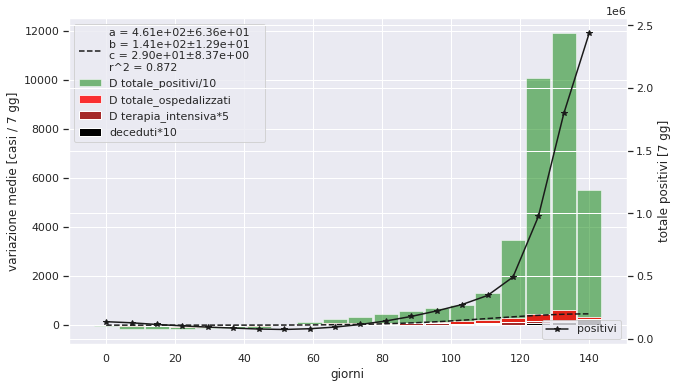

In [7]:
def do_av_plot(df=df, average_day = 7, day_start = 90, x_fit=0):
  fig, ax = plt.subplots(figsize=(10,6))
  df_org = df.copy()
  d0 = day_start
  df = df.tail(day_start)
  if x_fit==0:
    x_fit=day_start-10
  day_start = day_start/average_day

  x, y, err = ManSdtSubArr(np.gradient(df['totale_positivi']), average_day)
  xt, yt, errt = ManSdtSubArr(df['totale_positivi'], average_day)
  xn, yn, errn = ManSdtSubArr(df['nuovi_positivi'], average_day)
  ax.bar(x,y/10,color='green', width=average_day, label='D totale_positivi/10', alpha=0.5)


  print ("Tsso POSITIVI [%]")
  print (100*y[1:]/yt[:-1])
  print (y[-2:], yt[-2:], yn[-2:])

  x, y, err = ManSdtSubArr(np.gradient(df['totale_ospedalizzati']), average_day)
  xt, yt, errt = ManSdtSubArr(df['totale_ospedalizzati'], average_day)

  ax.bar(x,y,color='red', width=average_day, label='D totale_ospedalizzati', alpha=0.8)
  print ("Tsso OSPEDALIZZATI [%]")
  print (100*y[1:]/yt[:-1])
  try:

    sx = x[0:2*x_fit].std()
    ax, par = fittalo(Gauss3,x,y, ax, [y.max(),x_fit, sx], fmt='k--')
    print ("parametri fit gaussuano: ", par)
    print ("2 sigma dal picco {:d}, oggi {:d}".format(int(par[1]+3*par[2]), int(x[-1])))
    day=int(len(df_org)-d0+par[1])
    ax.axvline(par[1], color='black', linestyle='--', label='{:s} day: {:d}'.format(df_org.iloc[day, 0][0:10], day), alpha=0.5)
  except:
    print ("fit error...")

  x, y, err = ManSdtSubArr(np.gradient(df['terapia_intensiva']), average_day)
  xt, yt, errt = ManSdtSubArr(df['terapia_intensiva'], average_day)
  ax.bar(x,y*5,color='brown', width=average_day, label='D terapia_intensiva*5')
  print ("Tsso TERAPIA INTENSIVA [%]")
  print (100*y[1:]/yt[:-1])

  x, y, err = ManSdtSubArr(np.gradient(np.gradient(df['deceduti'])), average_day)
  xt, yt, errt = ManSdtSubArr(df['deceduti'], average_day)
  ax.bar(x,y*10,color='black', width=average_day, label='deceduti*10')
  print ("Tsso DECEDUTI [%]")
  print (100*y[1:]/yt[:-1])

  ax.set_xlabel('giorni')
  ax.set_ylabel('variazione medie [casi / {:d} gg]'.format(average_day))
  ax.legend()
  ax = ax.twinx()
  x = np.linspace(0, len(df['data']), len(df['data']))
  x, y, err = ManSdtSubArr(df['totale_positivi'], average_day)
  ax.plot(x,y, 'k*-', label='positivi')
  ax.legend(loc=4)
  ax.set_ylabel('totale positivi [{:d} gg]'.format(average_day))
  plt.show()
do_av_plot(df=df, average_day = 7, day_start = 140, x_fit=0)

In [8]:
x/7

array([ 0.        ,  1.01020408,  2.02040816,  3.03061224,  4.04081633,
        5.05102041,  6.06122449,  7.07142857,  8.08163265,  9.09183673,
       10.10204082, 11.1122449 , 12.12244898, 13.13265306, 14.14285714,
       15.15306122, 16.16326531, 17.17346939, 18.18367347, 19.19387755,
       20.20408163, 21.21428571, 22.2244898 , 23.23469388, 24.24489796,
       25.25510204, 26.26530612, 27.2755102 , 28.28571429, 29.29591837,
       30.30612245, 31.31632653, 32.32653061, 33.33673469, 34.34693878,
       35.35714286, 36.36734694, 37.37755102, 38.3877551 , 39.39795918,
       40.40816327, 41.41836735, 42.42857143, 43.43877551, 44.44897959,
       45.45918367, 46.46938776, 47.47959184, 48.48979592, 49.5       ,
       50.51020408, 51.52040816, 52.53061224, 53.54081633, 54.55102041,
       55.56122449, 56.57142857, 57.58163265, 58.59183673, 59.60204082,
       60.6122449 , 61.62244898, 62.63265306, 63.64285714, 64.65306122,
       65.66326531, 66.67346939, 67.68367347, 68.69387755, 69.70

Tsso POSITIVI [%]
[110.54958008  50.79175211  22.55426147   7.94748013   3.22136564
   1.65480372   0.40658295  -0.36926019  -1.33507248  -2.14244969
  -2.64893941  -2.41086352  -3.15515431]
[-1712.35714286 -1828.28571429] [57946.         44596.42857143] [550.85714286 422.85714286]
Tsso OSPEDALIZZATI [%]
[ 1.58500149e+02  4.08476879e+01  1.40456414e+01  4.34989295e+00
  8.31188076e-03 -6.04178849e-01 -2.06339659e+00 -2.56820093e+00
 -2.34023510e+00 -2.96221742e+00 -2.73869792e+00 -2.67976361e+00
 -3.23066801e+00]
parametri fit gaussuano:  [-726.14644454   68.00202887   14.24266541]
2 sigma dal picco 110, oggi 98
Tsso TERAPIA INTENSIVA [%]
[120.22292994  33.10004117  12.10179076   2.95079493  -1.07710816
  -2.19290362  -2.94179011  -3.11086855  -3.04324251  -4.15418142
  -2.89493865  -3.29255128  -2.75744265]
Tsso DECEDUTI [%]
[ 8.91483516e+01  1.25000000e+01  2.37976407e+00  2.08252759e-01
 -2.70384787e-01 -3.51617440e-03 -7.57207287e-02 -8.61542824e-02
 -8.83310594e-03 -5.30336764e-02

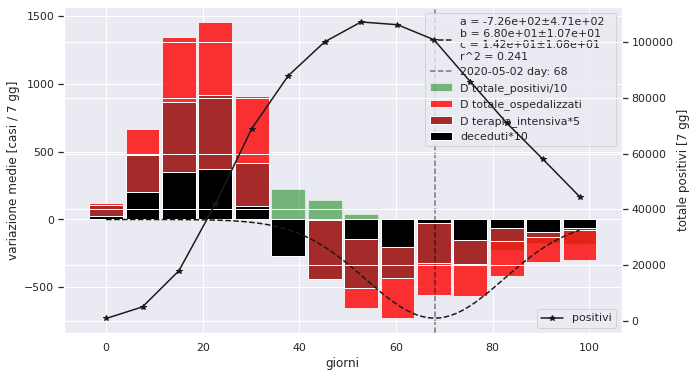

In [9]:
# prima ondata
do_av_plot(df=df.head(100), average_day = 7, day_start = 100)

Tsso POSITIVI [%]
[-0.97663528 -1.58088751 -1.1316534  -1.69702879 -1.17897137 -0.94233906
 -0.16100503 -0.74841905  0.66976333  1.34549248  1.91095922  2.53506741
  3.81981407  3.95006301  3.94021312  3.91377341  4.57324176  7.01903798
 15.36034046 13.13189086  4.59288061]
[10660.          6955.71428571] [151445.57142857 209997.42857143] [13190.         11775.57142857]
Tsso OSPEDALIZZATI [%]
[-1.13045444 -0.65198803 -0.05975143 -0.42047093 -1.14551863 -0.7183852
 -1.38333333 -0.82950935  1.92153723  3.25800377  2.94985251  2.4668435
  2.1957914   0.52313883  1.3470116   0.9921671   1.68360864  2.24544242
  3.5945126   3.72133276  2.49558304]
parametri fit gaussuano:  [456.73180644 325.82291538  80.72282907]
2 sigma dal picco 567, oggi 154
fit error...
Tsso TERAPIA INTENSIVA [%]
[ 0.84427767 -1.19926199 -0.18050542 -1.73469388  0.85470085 -0.52304675
 -2.02020202  0.          0.14492754  2.59365994  0.97765363  3.37349398
  2.05338809  1.91637631  2.01863354  0.0748503   1.98717949  1.

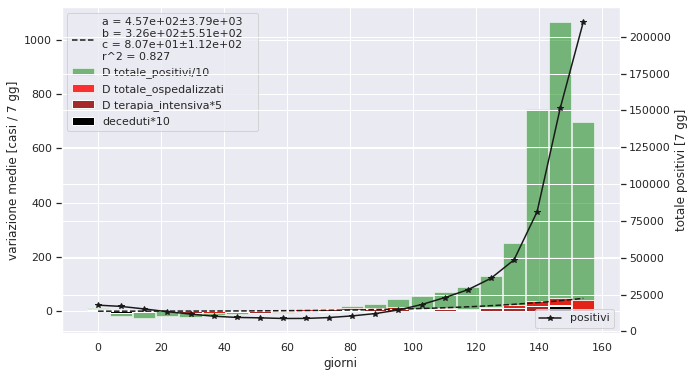

In [10]:
# Lazio
do_av_plot(df=Lazio, average_day = 7, day_start = 160)

2022-01-18 00:00:00 34 70
2022-02-21 00:00:00


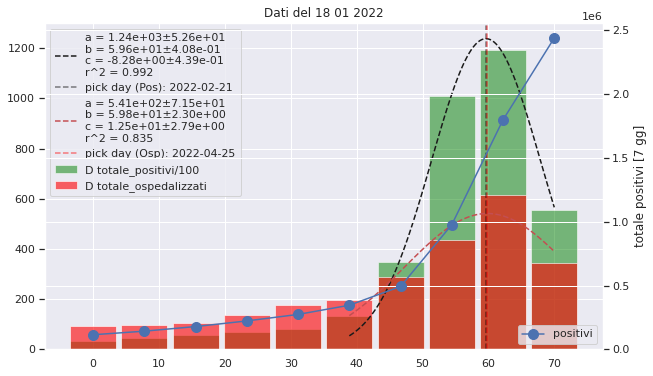

In [53]:
def do_av_plot(df=df, average_day = 7, day_start = 140, x_fit=0, w_fit=35, posscaele=100):
  import datetime
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  
  #import seaborn as sns 

  fig, ax = plt.subplots(figsize=(10,6))
  df_org = df.copy()
  d0 = day_start
  tdel = df.data.values[-1].split("T")[0].split("-")
  df = df.tail(day_start)
  
  if x_fit==0:
    x_fit=day_start-10
  day_start = int(day_start/average_day)
  fit_start = int(w_fit/average_day)

  x, y, err = ManSdtSubArr(np.gradient(df['totale_positivi']), average_day)
  xt, yt, errt = ManSdtSubArr(df['totale_positivi'], average_day)

  ax.bar(x,y/posscaele,color='green', width=average_day, label='D totale_positivi/'+str(posscaele), alpha=0.5)

  sx = x[0:2*x_fit].std()
  fiiting = False
  try:
    ax, par = fittalo(Gauss3,x[-fit_start:],y[-fit_start:]/posscaele, ax, [y.max(),x_fit, sx], fmt='k--')
    fiiting = True
  except:
    par = [y.max(),x_fit, sx]
    pass
  pick_day = int(par[1]+3*par[2])
  day=int(len(df_org)-d0+par[1])
  last_data = datetime.datetime.strptime(df.iloc[-1, 0][0:10], "%Y-%m-%d")
  pick_date = last_data + datetime.timedelta(days=(pick_day))
  print(last_data,  pick_day, int(x[-1]))
  print(pick_date)
  if par[1]>day_start*average_day:
    dove = x_fit
  else:
    dove = par[1]
  if fiiting:
    ax.axvline(dove, color='black', linestyle='--', label='pick day (Pos): {:s}'.format(pick_date.strftime('%Y-%m-%d')), alpha=0.5)

  x, y, err = ManSdtSubArr(np.gradient(df['totale_ospedalizzati']), average_day)
  xt, yt, errt = ManSdtSubArr(df['totale_ospedalizzati'], average_day)
  fiiting = False
  try:
    ax, par = fittalo(Gauss3,x[-fit_start:],y[-fit_start:], ax, [y.max(),x_fit, sx], fmt='r--')
    fiiting = True
  except:
    par = [y.max(),x_fit, sx]
    pass
  pick_day = int(par[1]+3*par[2])
  day=int(len(df_org)-d0+par[1])
  last_data = datetime.datetime.strptime(df.iloc[-1, 0][0:10], "%Y-%m-%d")
  pick_date = last_data + datetime.timedelta(days=(pick_day))
  if par[1]>day_start*average_day:
    dove = x_fit
  else:
    dove = par[1]
  if fiiting:
    ax.axvline(dove, color='red', linestyle='--', label='pick day (Osp): {:s}'.format(pick_date.strftime('%Y-%m-%d')), alpha=0.5)

  ax.bar(x,y,color='red', width=average_day, label='D totale_ospedalizzati', alpha=0.6)

  ax.legend()
  ax = ax.twinx()
  x = np.linspace(0, len(df['data']), len(df['data']))
  x, y, err = ManSdtSubArr(df['totale_positivi'], average_day)
  ax.plot(x,y, 'b.-', label='positivi', markersize=20)
  ax.set_ylim(bottom=0)
  ax.legend(loc=4)
  ax.set_ylabel('totale positivi [{:d} gg]'.format(average_day))
  ax.set_title("Dati del {:s} {:s} {:s}".format(tdel[2], tdel[1], tdel[0]))
  plt.show()
  #fig.savefig('./tassicovid.png')
  #plt.close(fig)
do_av_plot(df=df, average_day = 7, day_start = 70, x_fit=0, w_fit=35, posscaele=100)

In [12]:
import datetime
date_1 = datetime.datetime.strptime(df.iloc[-1, 0][0:10], "%Y-%m-%d")
end_date = date_1 + datetime.timedelta(days=100)
print(end_date.strftime('%Y-%m-%d'))

2022-04-28


Max 38 3940
Max 730 4728
Max 37 743
Max 730 891


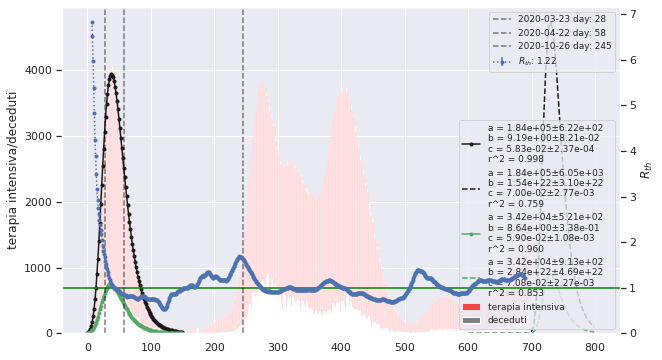

In [20]:
def predicGem(df=df, P_start=220, P_max = 285, slope=1):
  fig, ax = plt.subplots(figsize=(10,6))
  x = np.linspace(0, len(df['data']), len(df['data']))
  
  y = np.array(df['terapia_intensiva'])
  ax.bar(x,y, color='red', alpha=0.7, label='terapia intensiva', width=1)
  ax, par = fittalo(dGompertz, x[x<150], y[x<150], ax, [1e5,9., 0.1], 'k.-')
  print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
  
  # Gompertz
  # a is the asymptote limit of grow
  # b sets the displacement along the x-axis 
  # c sets the growth rate (y scaling)
  c = par[2]*slope
  a = par[0]
  b = np.exp(P_max*c)
 
  xp = np.linspace(P_start, P_start+199, 200)
 
  yp = dGompertz(xp,*[a,b,c])
 
  for i in range(P_start, len(x)):
    yp[i-P_start]=y[i]
 
  
  ax, par = fittalo(dGompertz, xp, yp, ax, [a,b,c], 'k--')
  print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
 
  
  y = np.gradient(df['deceduti'])
 
  ax.bar(x,y, color='gray', alpha=1, label='deceduti', width=1)
  ax, par = fittalo(dGompertz, x[x<150], y[x<150], ax, [3e4,8., 0.1], 'g.-')
  print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
  
  c = par[2]*slope
  a = par[0]
  b = np.exp(P_max*c)
 
  xp = np.linspace(P_start, P_start+199, 200)
 
  yp = dGompertz(xp,*[a,b,c])
  for i in range(P_start, len(x)):
 
    yp[i-P_start]=y[i]
 
  
  ax, par = fittalo(dGompertz, xp, yp, ax, [a,b,c], 'g--')
  print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
  
  
  ax.set_ylabel(r'terapia intensiva/deceduti')
  ax.set_ylim(bottom=0)
  ax.legend(loc=4, prop={'size': 9})
  ax = ax.twinx()
  
  # ricoverati_con_sintomi
  # nuovi_positivi
  data = df['ricoverati_con_sintomi']
  x_ , y_ = Rth(data, 7 , 7)
  
  ax.errorbar(x_, y_, yerr=0, fmt='b.:', label='$R_{th}$'+': {0:.2f}'.format(y_[-1]))
  ax.axhline(1, color='green')
  ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
  ax.set_ylabel(r'$R_{th}$')
  day=28
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  day=58
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  day=245
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  
  ax.legend(loc=1, prop={'size': 9})
  ax.set_ylim(bottom=0)
  ax.grid()
  plt.show()
  #
predicGem(df=Italia, P_start=600, P_max = 730, slope=1.2)

Max 37 1342
Max 687 268


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in multiply


Max 33 393
Max 691 63


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in multiply


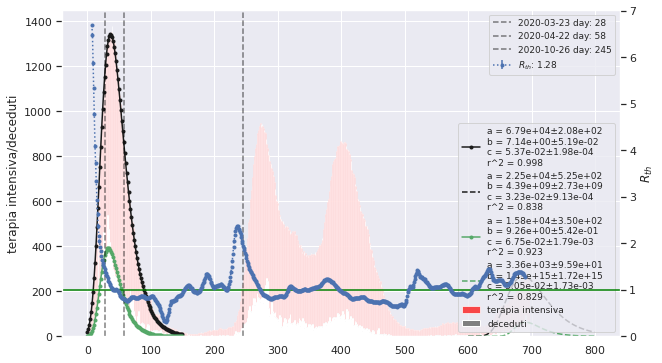

In [21]:
predicGem(df=Lombardia, P_start=600, P_max = 650, slope=0.7)

Max 48 196
Max 750 196
Max 53 11
Max 704 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in multiply


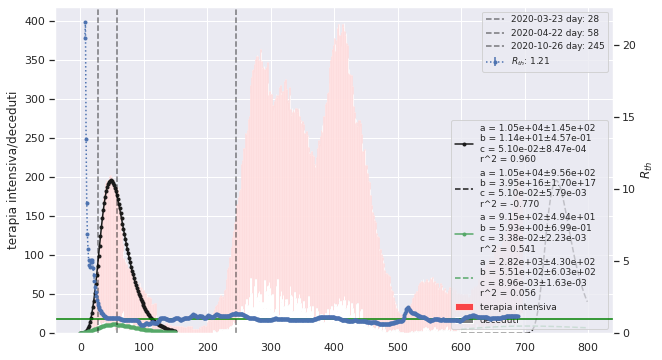

In [22]:
predicGem(df=Lazio, P_start=600, P_max = 750, slope=1)

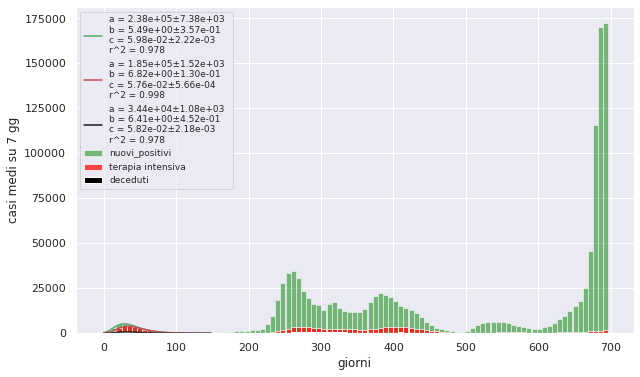

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
average_day = 7
# y = df['totale_positivi']
# x, y, err = ManSdtSubArr(y, average_day)
# ax.plot(x,y, 'b.', alpha=0.5, label='totale_positivi') 
 
y = df['nuovi_positivi']
x, y, err = ManSdtSubArr(y, average_day)
ax.bar(x,y, color='green', alpha=0.5, label='nuovi_positivi', width=average_day) 
fittalo(dGompertz, x[x<150], y[x<150], ax, [4e6,7., 0.1], 'g')
y = df['terapia_intensiva']
x, y, err =  ManSdtSubArr(y, average_day)
ax.bar(x,y, color='red', alpha=0.7, label='terapia intensiva', width=average_day)
fittalo(dGompertz, x[x<150], y[x<150], ax, [1e5,9., 0.1], 'r')
 
y = np.gradient(df['deceduti'])
x, y, err =  ManSdtSubArr(y, average_day)
ax.bar(x,y, color='black', alpha=1, label='deceduti', width=average_day)
fittalo(dGompertz, x[x<150], y[x<150], ax, [3e4,8., 0.1], 'k')
ax.set_xlabel('giorni')
ax.set_ylabel('casi medi su 7 gg')
ax.legend(loc=2, prop={'size': 9})
#ax.grid()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp


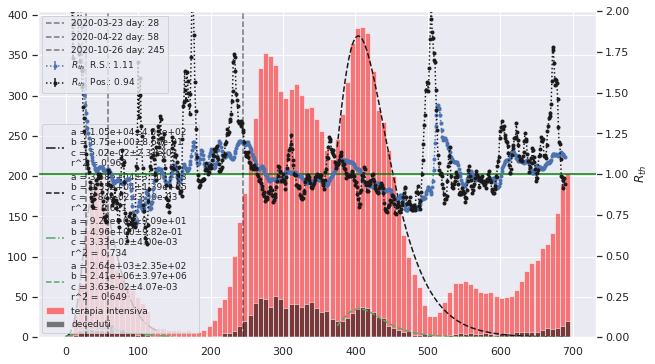

In [25]:
def do_av_fit(df=df, average_day = 7, P_start = 180, exp_peak = 275, RthN = 7, RthD = 4):
  fig, ax = plt.subplots(figsize=(10,6))
 
 
  y = np.array(df['terapia_intensiva'])
  x, y, err =  ManSdtSubArr(y, average_day)
  ax.bar(x,y, color='red', alpha=0.5, label='terapia intensiva', width=average_day)
  ax, par = fittalo(dGompertz, x[x<130], y[x<130], ax, [1e5,9., 0.1], 'k-.')
 
  # Gompertz
  # a is the asymptote limit of grow
  # b sets the displacement along the x-axis 
  # c sets the growth rate (y scaling)
  c = par[2]
  a = par[0]
  b = np.exp(exp_peak*c)
  try:
    ax, par = fittalo(dGompertz, x[x>P_start], y[x>P_start], ax, [a,b,c], 'k--')
  except:
    print ("unfittable")
 
  y = np.gradient(df['deceduti'])
  x, y, err =  ManSdtSubArr(y, average_day)
  ax.bar(x,y, color='black', alpha=0.5, label='deceduti', width=average_day)
  ax, par = fittalo(dGompertz, x[x<150], y[x<150], ax, [3e4,8., 0.1], 'g-.')
 
  # Gompertz
  # a is the asymptote limit of grow
  # b sets the displacement along the x-axis 
  # c sets the growth rate (y scaling)
  c = par[2]
  a = par[0]
  b = np.exp(exp_peak*c)
  try:
    ax, par = fittalo(dGompertz, x[x>P_start], y[x>P_start], ax, [a,b,c], 'g--')
  except:
    print ("unfittable")
  ax.legend(loc=3, prop={'size': 9})
  ax = ax.twinx()
  
  data = df['ricoverati_con_sintomi']
  x_ , y_ = Rth(data, RthN, RthD )
  
  # ax.errorbar(x, y, yerr=0, fmt='k.:', label='running avarege')
  ax.errorbar(x_, y_, yerr=0, fmt='b.:', label='$R_{th}$'+'  R.S.: {0:.2f}'.format(y_[-1]))
  data = df['nuovi_positivi']
  x_ , y_ = Rth(data, RthN, RthD )
  ax.errorbar(x_, y_, yerr=0, fmt='k.:', label='$R_{th}$'+'  Pos.: {0:.2f}'.format(y_[-1]))
  ax.axhline(1, color='green')
  ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
  ax.set_ylabel(r'$R_{th}$')
  day=28
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  day=58
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  day=245
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  
  ax.legend(loc=2, prop={'size': 9})
  ax.set_ylim(bottom=0, top=2)
  ax.grid()
  plt.show()
do_av_fit(df=Lazio, average_day = 7, P_start=370, exp_peak=400, RthN = 7, RthD = 4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp


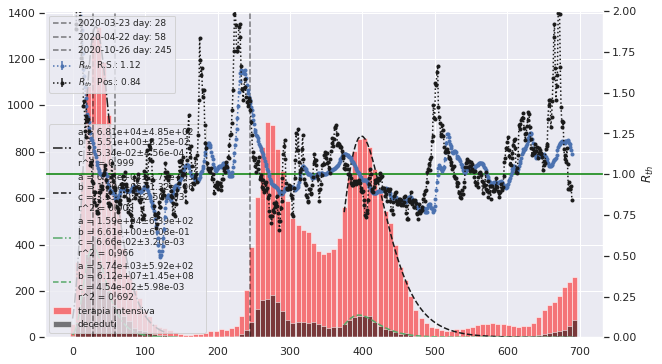

In [26]:
do_av_fit(df=Lombardia, average_day = 7, P_start=370, exp_peak=450, RthN = 7, RthD = 4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp


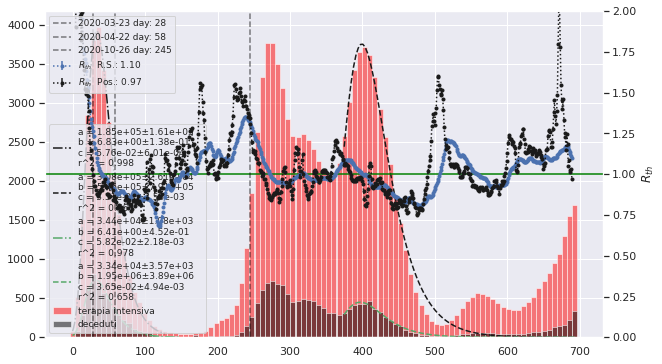

In [27]:
do_av_fit(df=Italia, average_day = 7, P_start=370, exp_peak=450, RthN = 7, RthD = 4)

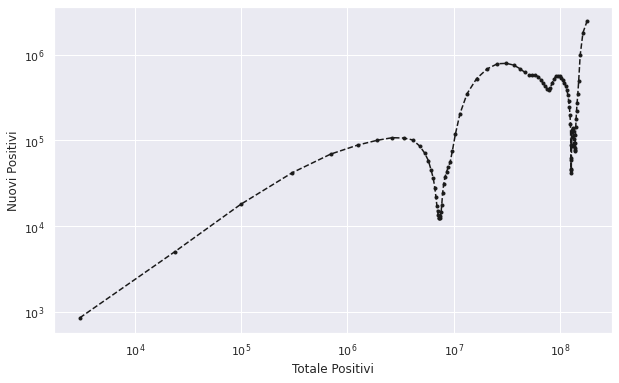

In [28]:
from scipy import integrate
fig, ax = plt.subplots(figsize=(10,6))
xi, yi, eri = ManSdtSubArr(integrate.cumtrapz(df['totale_positivi']),7)
xp, yp, eri = ManSdtSubArr(df['totale_positivi'],7)
ax.plot(yi,yp,'k.--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Totale Positivi')
ax.set_ylabel('Nuovi Positivi')
plt.show()

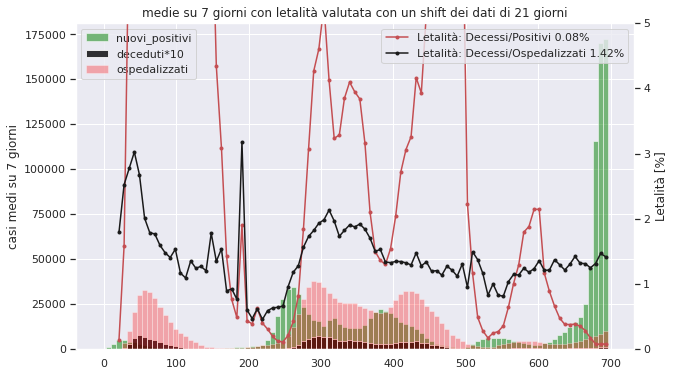

In [84]:
def letalita(df=df, average_day = 7, day_shift=14, day_start = 90):
  fig, ax = plt.subplots(figsize=(10,6))
  df_org = df.copy()
  d0 = day_start
  df = df.tail(day_start)
  day_start = day_start/average_day
 
 
 
  x, y, err    = ManSdtSubArr(df['nuovi_positivi'], average_day)
  xt, yt, errt = ManSdtSubArr(np.gradient(df['deceduti']), average_day)
  xo, yo, erro = ManSdtSubArr(df['totale_ospedalizzati'], average_day)
 
  ax.bar(x,y, color='green', alpha=0.5, label='nuovi_positivi', width=average_day) 
  week_shift = int(day_shift/average_day)
  # print("no", x)
  # print("no", y)
  # print(week_shift) 
  if week_shift !=0:

    x=x[week_shift:]
    y=y[week_shift:]
    yt=yt[:-week_shift]
    yo=yo[:-week_shift]
    # print("shift", x)
    # print("shift", y)
    # print(yt)
    # print(yo)
  ax.bar(x,yt*10, color='black', alpha=0.8, label='deceduti*10', width=average_day)
  ax.bar(x,yo, color='red', alpha=0.3, label='ospedalizzati', width=average_day) 
  ax.set_ylabel('casi medi su {:d} giorni'.format(average_day))
  ax.legend(loc=2)
  ax = ax.twinx()
  ratio = (yt/y)*100
  ax.plot(x,ratio,'r.-', label='Letalità: Decessi/Positivi {:.2f}%'.format(ratio[-1]))
  ratio = (yt/yo)*100
  ax.plot(x,ratio,'k.-', label='Letalità: Decessi/Ospedalizzati {:.2f}%'.format(ratio[-1]))
 
  ax.legend(loc=1)
  ax.set_ylim(0,5)
  ax.set_ylabel('Letalità [%]')
  ax.grid()
  plt.title('medie su {:d} giorni con letalità valutata con un shift dei dati di {:d} giorni'.format(average_day, day_shift))
  plt.show()
letalita(df=df, average_day = 7, day_shift=21, day_start = len(df))

In [64]:
a = [1, 2, 3, 4, 5, 6, 7, 8]
a[:-2]

[1, 2, 3, 4, 5, 6]

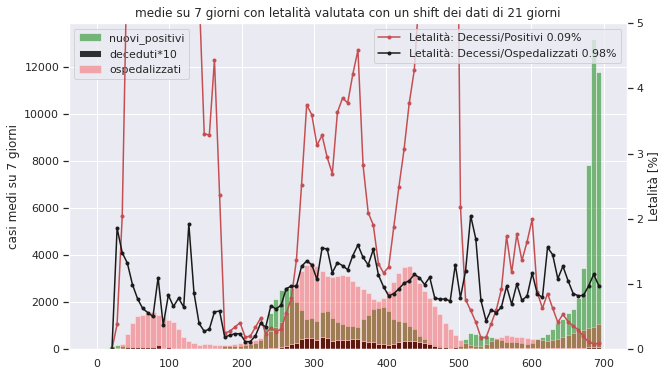

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2
14580,2022-01-18T17:00:00,ITA,12,Lazio,41.89277,12.483667,1849,207,2056,227490,229546,8013,13286,476255,9561,NaN,NaN,715362,14553650,5161083.0,NaN,18.0,NaN,NaN,643607.0,71755.0,7354329.0,7199321.0,ITI,ITI4


In [83]:
letalita(df=Lazio, average_day = 7, day_shift=21, day_start = len(Lazio))
Lazio.tail(1)

Olbia-Tempio >>> non esiste
Carbonia-Iglesias >>> non esiste
Medio Campidano >>> non esiste
Ogliastra >>> non esiste


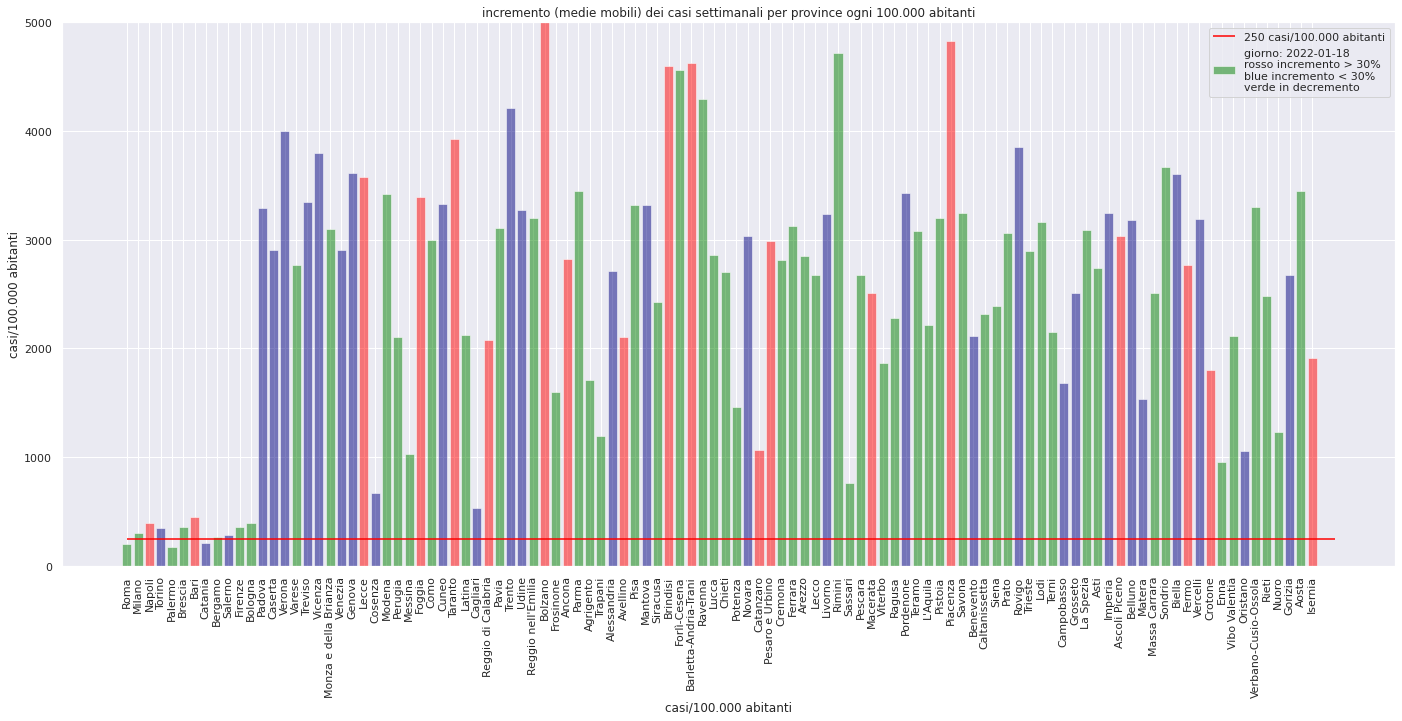

In [46]:
def casi_provincia(dp, provincia):
  try:
    dfc = dp.loc[(dp['denominazione_provincia'] == provincia)].sort_values(by="data").copy()
    x, y, err = ManSdtSubArr(np.gradient(dfc['totale_casi'])/(pr[pr.Provincia==provincia].Popolazione.values/100000), average_day)
  except:
    print(provincia+" >>> non esiste")
    x = y = err = []
  return x, y, err
def plot_p(p,c, date, h=True, save=True):
  if h:
    fig, ax = plt.subplots(figsize=(23.9, 10))
  else:
    fig, ax = plt.subplots(figsize=(10.80,19.20))
  clrs = ['red' if (x[0] > 1.3*x[1]) else 'green' if (x[0] < x[1]) else 'navy' for x in c ]
  c = np.array(c)
  if h:
    ax.bar(p, c[:,0], align='center', color=clrs, alpha=0.5, 
            label='giorno: {:s}\nrosso incremento > 30%\nblue incremento < 30%\nverde in decremento'.format(str(date)[0:10]))
    ax.hlines(250, 0, 107, color='red', label='250 casi/100.000 abitanti')
    ax.set_ylabel('casi/100.000 abitanti')
    ax.set_xlabel('province')
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center')
  else: 
    ax.barh(p, c[:,0], align='center', color=clrs, alpha=0.5, 
          label='giorno: {:s}\nrosso incremento > 30%\nblue incremento < 30%\nverde in decremento'.format(str(date)[0:10]))
    ax.vlines(250, 0, 107, color='red', label='250 casi/100.000 abitanti')
    ax.set_xlabel('casi/100.000 abitanti')
    ax.set_ylabel('province')
  ax.set_title('incremento (medie mobili) dei casi settimanali per province ogni 100.000 abitanti')
  ax.set_xlabel('casi/100.000 abitanti')
  ax.set_ylim(0,5000)
  plt.legend()
  if save:
    png_dir = './drive/MyDrive/tmp/'
    png_image = png_dir+'img{:d}.png'.format(j)
    fig.savefig(png_image, bbox_inches='tight')
  else:
    plt.show()
#
# crea film jpg
##############
#
# import datetime as dt
# date = dt.datetime(2021, 2, 1)
# from google.colab import drive
# drive.mount('/content/drive')
 
# average_day = 7
# dfc = dp.loc[(dp['denominazione_provincia'] == 'Roma')].sort_values(by="data").copy()
 
# for j in range(len(dfc[(dfc.data>str(date))])):
#   date += dt.timedelta(days=1)
#   p = []
#   c = []
#   for i, provincia in enumerate(pr.Provincia):
#     x, y , err = casi_provincia(dp[dp.data<str(date)], provincia)
#     if len(y):
#       p.append(provincia)
#       c.append([y[-1], y[-2]])
#   plot_p(p,c, date, h=True)
################
p = []
c = []
for i, provincia in enumerate(pr.Provincia):
  x, y , err = casi_provincia(dp, provincia)
  if len(y):
    p.append(provincia)
    c.append([y[-1], y[-2]])
date = dp.data.values[-1]
plot_p(p,c, date, h=True, save=False)

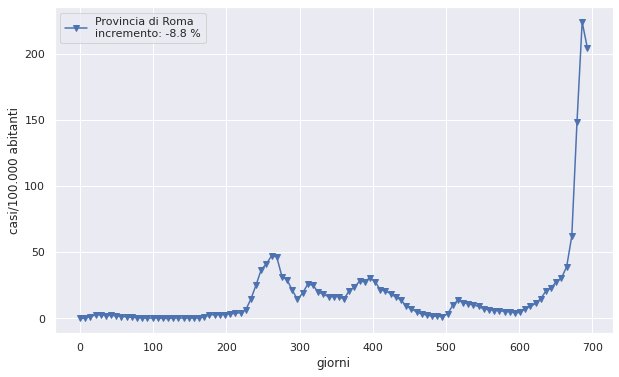

In [33]:
provincia='Roma'
x,y, err = casi_provincia(dp, provincia)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, y, 'bv-', label='Provincia di '+provincia+'\nincremento: {:.1f} %'.format(100*(y[-1]-y[-2])/y[-2]))
ax.set_xlabel('giorni')
ax.set_ylabel('casi/100.000 abitanti')
plt.legend()
plt.show()

simulazione interperatione errone dati inglesi:

https://www.databaseitalia.it/i-decessi-in-eccesso-nel-2021-indicano-lagenda-dello-spopolamento/

dati reali:

https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/bulletins/deathsinvolvingcovid19byvaccinationstatusengland/deathsoccurringbetween2januaryand24september2021



In [34]:
# https://www.istat.it/it/archivio/240401
dItaDead = panda_from_gspreadsheet('1JhAzNarOKvpeOesaxsX3lhK1cldVI_Oy', sheet_name='Decessi totali 2021', header=0)
dItaDeadInt = []
for i, value in enumerate(dItaDead.tail(1).values[0][1:-1]):
  if i == 0:
    dItaDeadInt.append(value)
  else:
    dItaDeadInt.append(dItaDeadInt[i-1]+value)
print(dItaDeadInt)
dItaDead

[73970, 133053, 201302, 264408, 318895, 370655, 423615, 479101, 529061]


,Regione\ripartizione,gennaio,febbraio,marzo,aprile,maggio,giugno,luglio,agosto,settembre,ottobre (stima)
0,Piemonte,5807,4536,5762,5329,4326,3948,4169,4203,4002,4252
1,Valle d'Aosta,151,128,135,162,119,92,100,116,122,119
2,Lombardia,11009,8793,11083,9726,8581,7731,7905,8063,7513,8125
3,Bolzano,505,529,457,377,378,378,358,382,361,376
4,Trento,711,486,529,481,361,415,390,368,378,435
5,Veneto,6664,4432,4894,4517,4003,3830,3865,3875,3904,4186
6,Friuli-Venezia Giulia,2185,1503,1804,1488,1134,1100,1155,1089,1105,1194
7,Liguria,2426,1948,1981,2012,1754,1680,1760,1729,1612,1714
8,Emilia-Romagna,6114,4772,5475,4704,4194,4019,4039,4148,4053,4347
9,Toscana,4506,3836,4552,4373,3769,3540,3527,3924,3603,3841


In [35]:
dItaDead.columns.values[1:]
dItaDead.tail(1).values[0][1:]

array([73970, 59083, 68249, 63106, 54487, 51760, 52960, 55486, 49960,
       52734], dtype=object)

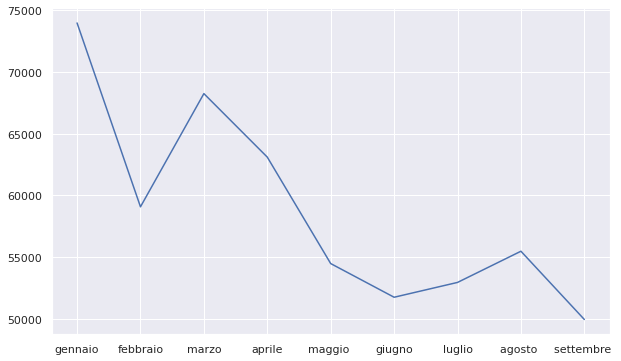

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(dItaDead.columns.values[1:-1], dItaDead.tail(1).values[0][1:-1])
plt.show()

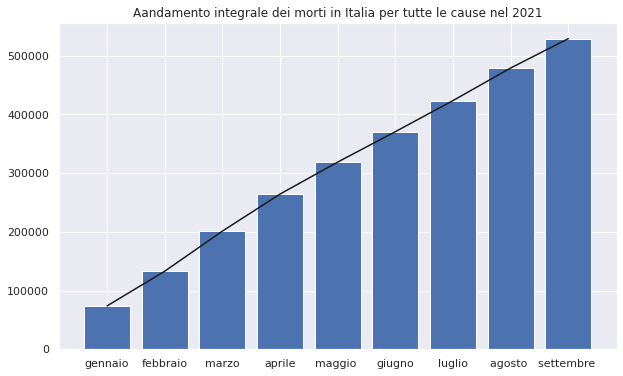

In [37]:
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(dItaDead.sum()[1:-1].index.values, dItaDeadInt)
ax.plot(dItaDead.sum()[1:-1].index.values, dItaDeadInt, 'k-')

ax.set_title("Aandamento integrale dei morti in Italia per tutte le cause nel 2021")
ax.set_ylim(0,)
plt.show()

In [38]:
# dati ufficiali vaccinazioni 
# https://github.com/italia/covid19-opendata-vaccini
url_csv_file = "https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-summary-latest.csv"
dVac = pd.read_csv(url_csv_file)
dVac

,data_somministrazione,area,totale,sesso_maschile,sesso_femminile,prima_dose,seconda_dose,pregressa_infezione,dose_addizionale_booster,codice_NUTS1,codice_NUTS2,codice_regione_ISTAT,nome_area
0,2021-01-26,MAR,2020,747,1273,77,1942,1,0,ITI,ITI3,11,Marche
1,2021-03-09,CAL,6666,3466,3200,5605,992,69,0,ITF,ITF6,18,Calabria
2,2021-05-17,VEN,26552,13001,13551,15618,10082,852,0,ITH,ITH3,5,Veneto
3,2021-11-02,PUG,11044,5674,5370,1429,4231,172,5212,ITF,ITF4,16,Puglia
4,2021-11-03,ABR,5001,2609,2392,453,1828,65,2655,ITF,ITF1,13,Abruzzo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8027,2021-04-15,MOL,1975,814,1161,1107,859,9,0,ITF,ITF2,14,Molise
8028,2021-07-11,PAT,1044,567,477,134,901,9,0,ITH,ITH2,4,Provincia Autonoma Trento
8029,2021-08-11,VEN,26871,14846,12025,15652,10597,622,0,ITH,ITH3,5,Veneto
8030,2021-09-19,MOL,15,13,2,13,2,0,0,ITF,ITF2,14,Molise


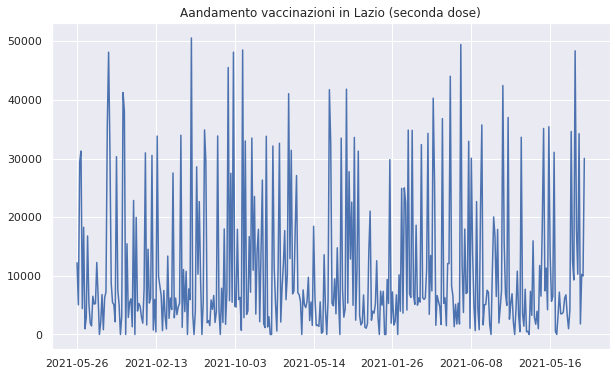

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Aandamento vaccinazioni in Lazio (seconda dose)")
ax.plot(dVac[dVac.area=="LAZ"].data_somministrazione, dVac[dVac.area=="LAZ"].seconda_dose)
ax.set_xticks(range(0, dVac[dVac.area=="LAZ"].index.size, 60))
plt.show()

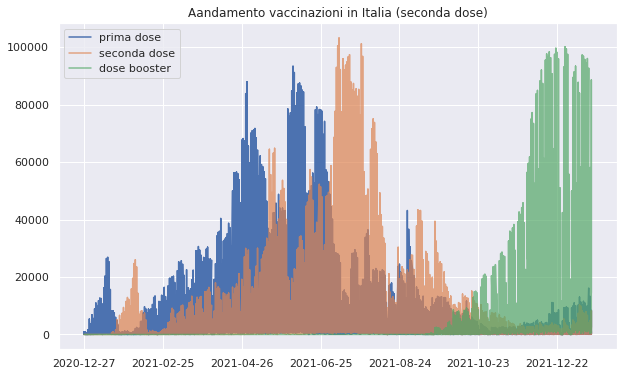

In [40]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Aandamento vaccinazioni in Italia (seconda dose)")
dVac=dVac.sort_values(by="data_somministrazione").copy()
ax.plot(dVac.data_somministrazione, dVac.prima_dose, label="prima dose")
ax.plot(dVac.data_somministrazione, dVac.seconda_dose, label="seconda dose", alpha=0.7)
ax.plot(dVac.data_somministrazione, dVac.dose_addizionale_booster, label="dose booster", alpha=0.7)

ax.set_xticks(range(0, dVac[dVac.area=="LAZ"].index.size, 60))
plt.legend()
plt.show()

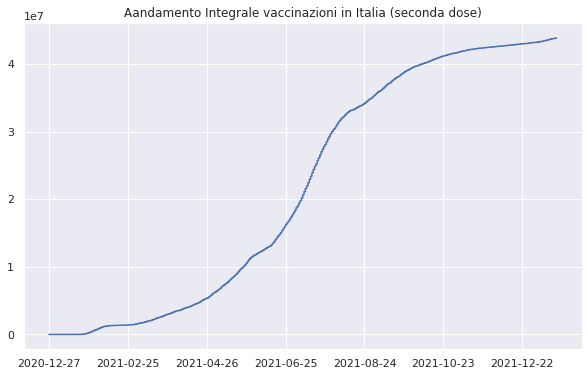

In [41]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Aandamento Integrale vaccinazioni in Italia (seconda dose)")
dVacDeadInt = []
for i, value in enumerate(dVac.seconda_dose):
  if i == 0:
    dVacDeadInt.append(value)
  else:
    dVacDeadInt.append(dVacDeadInt[i-1]+value)

ax.plot(dVac.data_somministrazione, dVacDeadInt)
ax.set_xticks(range(0, dVac[dVac.area=="LAZ"].index.size, 60))

plt.show()

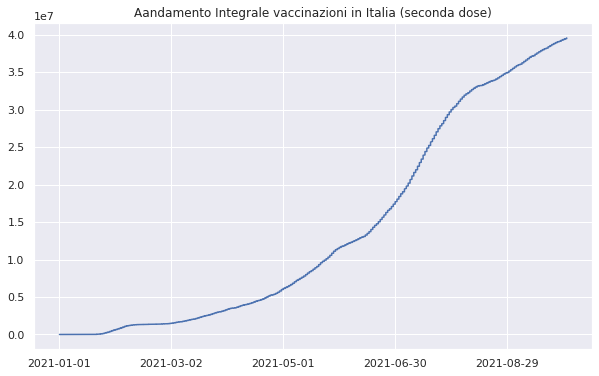

In [42]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Aandamento Integrale vaccinazioni in Italia (seconda dose)")
dVacDeadInt = []
dVacDeadIntM = []
dVacDeadM = np.zeros(9)
dVac=dVac[(dVac.data_somministrazione >= '2021-01-01') & (dVac.data_somministrazione < '2021-10-01')]

for i, value in enumerate(dVac.seconda_dose):
  if i == 0:
    dVacDeadInt.append(value)
  else:
    dVacDeadInt.append(dVacDeadInt[i-1]+value)
  for mese in range(len(dVacDeadM)):
    if int(dVac.iloc[i-1,0].split('-')[1]) == mese+1:
      dVacDeadM[mese]+=value
for mese, value in enumerate(dVacDeadM):
  if mese == 0:
    dVacDeadIntM.append(value)
  else:
    dVacDeadIntM.append(dVacDeadIntM[mese-1]+value)


ax.plot(dVac.data_somministrazione, dVacDeadInt)
ax.set_xticks(range(0, dVac[dVac.area=="LAZ"].index.size, 60))

plt.show()

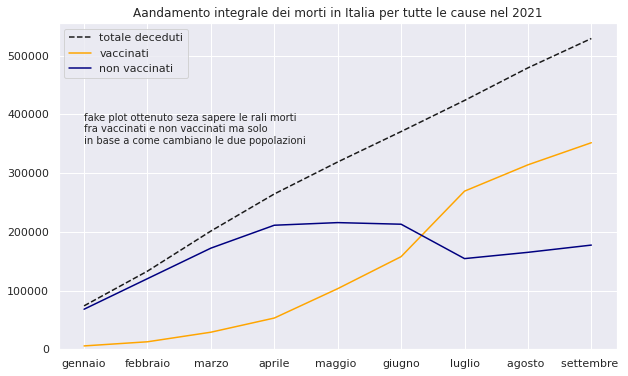

In [43]:
fig, ax = plt.subplots(figsize=(10,6))
#ax.bar(dItaDead.sum()[1:-1].index.values, dItaDeadInt)
ax.plot(dItaDead.sum()[1:-1].index.values, dItaDeadInt, 'k--', label="totale deceduti")
ax.plot(dItaDead.sum()[1:-1].index.values, (np.array(dVacDeadIntM)/59550000)*max(dItaDeadInt), '-', color='orange', label="vaccinati")
ax.plot(dItaDead.sum()[1:-1].index.values, (dItaDeadInt-(np.array(dVacDeadIntM)/59550000)*max(dItaDeadInt)), '-', color='navy', label="non vaccinati")
ax.set_title("Aandamento integrale dei morti in Italia per tutte le cause nel 2021")
ax.set_ylim(0,)
plt.text(0, 350000, "fake plot ottenuto seza sapere le rali morti \nfra vaccinati e non vaccinati ma solo \nin base a come cambiano le due popolazioni")
plt.legend()
plt.show()